In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
from gears import PertData, GEARS
import numpy as np
import pandas as pd
from tqdm import tqdm
import scanpy as sc
import anndata
from scipy.sparse import csr_matrix
import scipy.sparse as sp

In [7]:
data_dir = '/home/vinas/sc_perturbation_benchmark/data/frangieh_perturbciteseq_2021'

#### Download data

Instructions (credit to Romain Lopez, DCDFG)

1. Go to the data release [page](https://singlecell.broadinstitute.org/single_cell/study/SCP1064/multi-modal-pooled-perturb-cite-seq-screens-in-patient-models-define-novel-mechanisms-of-cancer-immune-evasion)
2. Login / Create an account
3. Click on Download
4. Click on Bulk Download option
5. Copy *only* the variable auth_code from the URL and paste it onto the auth_code of the URL for the curl command below (each authorization code only works for 30 minute), and run the command (had to customize it).
It should take under two minute

Download command:
```
curl -k "https://singlecell.broadinstitute.org/single_cell/api/v1/bulk_download/generate_curl_config?accessions=SCP1064&auth_code=Qo1e5U9N&directory=all" -o cfg.txt
curl -k -K cfg.txt && rm cfg.txt
```

#### Process data

In [49]:
data = sc.read_csv(f'{data_dir}/SCP1064/other/RNA_expression.csv.gz').transpose()

In [ ]:
# sparsify!
data_sp = sp.csr_matrix(data.X)

In [50]:
data.X = data_sp

In [51]:
# get covariates 
covariates =  pd.read_csv(f'{data_dir}/SCP1064/metadata/RNA_metadata.csv', index_col=0).iloc[1:, ]
data.obs = covariates
# correct dtypes
data.obs["MOI"] = data.obs["MOI"].astype(np.int32)
data.obs["UMI_count"] = data.obs["UMI_count"].astype(np.double)

In [52]:
# de-normalize and round up
norm_factor =  data.obs["UMI_count"].values / 1.0e6
Z = sp.diags(norm_factor).dot(np.expm1(data_sp))
print(np.greater_equal(np.abs(Z.data - np.rint(Z.data)), 0.01).any())
Z.data = np.rint(Z.data)
data.X = Z
Z.max()

False


4437.0

In [53]:
# read guide info
guide_info = pd.read_csv(f'{data_dir}/SCP1064/documentation/all_sgRNA_assignments.txt', index_col=0)
guide_info = guide_info.replace(np.nan,'',regex=True)
data.obs["sgRNAs"] = guide_info["sgRNAs"].astype(str)

In [54]:
adata = data

In [55]:
unique_gs = []
for index, row in tqdm(adata.obs.iterrows(), total=adata.n_obs):
    if row["sgRNAs"] != "":
        # get all guides in cells
        sg = row["sgRNAs"].split(",")
        # get gene name by stripping guide specific info
        sg_genes_ = [guide.rsplit("_", maxsplit=1)[0] for guide in sg]
        for gene in sg_genes_:
            unique_gs.append(gene)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 218331/218331 [00:09<00:00, 23355.20it/s]


In [56]:
sc.pp.filter_cells(adata, min_genes=500)
sc.pp.filter_genes(adata, min_cells=500)

In [57]:
# check gene sets and ensure matching with measurements
err = 0
ind = []
obs_genes = {}
unfound_genes = {}
targets = []
for index, row in tqdm(adata.obs.iterrows(), total=adata.n_obs):
    current_target = []
    if row["sgRNAs"] != "":
        # get all guides in cells
        sg = row["sgRNAs"].split(",")
        # get gene name by stripping guide specific info
        sg_genes = [guide.rsplit("_", maxsplit=1)[0] for guide in sg]
        for gene in sg_genes:
            if gene in adata.var.index:
                # gene is found
                current_target += [gene]
                if gene not in obs_genes:
                    obs_genes[gene] = 1
                else:
                    obs_genes[gene] += 1
            else:
                if gene not in unfound_genes:
                    unfound_genes[gene] = 1
                else:
                    unfound_genes[gene] += 1
    # end gene list
    targets += [",".join(current_target)]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 218027/218027 [00:09<00:00, 21895.31it/s]


In [58]:
# create regimes
regimes = np.unique(targets, return_inverse=True)[1]
adata.obs["targets"] = targets
adata.obs["regimes"] = regimes
adata.obs["culture"] = adata.obs["condition"]

In [59]:
# some leftover genes I couldn't match
unfound_genes.keys()

dict_keys(['NGFR', 'SERPINF1', 'CSPG4', 'PIK3IP1', 'ONE_NON-GENE_SITE', 'NO_SITE', 'NUP50-AS1', 'IDI2-AS1', 'CXCR4', 'JMJD7', 'TYR', 'BOLA2', 'LRRC75A-AS1', 'LINC00518', 'APOD', 'A2M', 'LEF1-AS1', 'SLC7A5P1', 'SERPINA3', 'WNT7A', 'GAS5', 'IRF4', 'APOC2', 'XAGE1A', 'CCND2', 'CDH19', 'ST6GALNAC2', 'S100B', 'HLA-H', 'SNHG6'])

<Axes: ylabel='Frequency'>

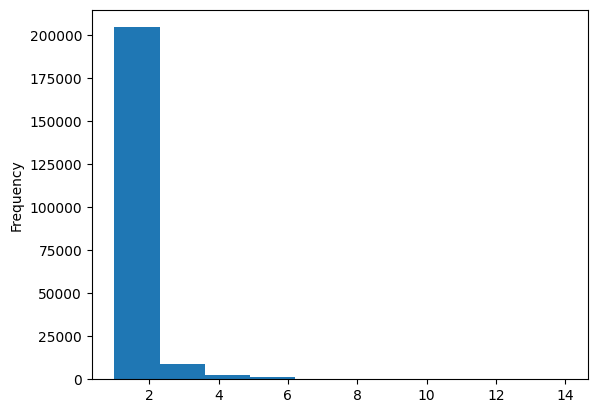

In [60]:
adata_subset = adata
adata_subset.obs['n_targets'] = adata_subset.obs['targets'].str.split(',').str.len()
# adata_subset.obs.loc[adata_subset.obs['control'], 'n_targets'] = 0
adata_subset[adata_subset.obs['n_targets'] > 0].obs['n_targets'].plot(kind='hist')

In [61]:
adata_subset.obs['control_nan_sgRNA'] = adata_subset.obs['sgRNAs'] == ''
adata_subset.obs['control_nosite_sgRNA'] = adata_subset.obs['sgRNAs'].str.startswith('NO_SITE')
# adata_subset.obs['control'] = # np.logical_or(adata_subset.obs['control_nan_sgRNA'].values, adata_subset.obs['control_nosite_sgRNA'].values)
# adata_subset.obs['control'] = adata_subset[adata_subset.obs['sgRNAs'].str.contains('_SITE_')]  # np.logical_or(adata_subset.obs['control_nan_sgRNA'].values, adata_subset.obs['control_nosite_sgRNA'].values)
adata_subset.obs['control'] = adata_subset.obs['sgRNA'].astype(str).str.contains('_SITE_')
adata_subset.obs['control_nan_sgRNA'].value_counts(), adata_subset.obs['control_nosite_sgRNA'].value_counts()

(control_nan_sgRNA
 False    195220
 True      22807
 Name: count, dtype: int64,
 control_nosite_sgRNA
 False    208866
 True       9161
 Name: count, dtype: int64)

In [66]:
# Keep cells with <=1 targets
adata_subset = adata_subset[adata_subset.obs['n_targets'] <= 1]
adata_subset.obs['targets'] = adata_subset.obs['targets'].replace({'': 'ctrl'})
adata_subset

AnnData object with n_obs × n_vars = 171210 × 15335
    obs: 'library_preparation_protocol', 'condition', 'MOI', 'sgRNA', 'UMI_count', 'sgRNAs', 'n_genes', 'targets', 'regimes', 'culture', 'n_targets', 'control_nan_sgRNA', 'control_nosite_sgRNA', 'control'
    var: 'n_cells'

In [67]:
# GEARS normalization
adata_subset.layers["counts"] = adata_subset.X.copy()
sc.pp.normalize_total(adata_subset)
sc.pp.log1p(adata_subset)
sc.pp.highly_variable_genes(adata_subset, n_top_genes=5000, subset=False)

In [68]:
# check that all perturbed genes are in var
condition_flag = []
targets = set()
for index, row in tqdm(adata_subset.obs.iterrows(), total=adata_subset.n_obs):
    current_target = []
    # get all guides in cells
    sg = row["targets"].split(",")
    # get gene name by stripping guide specific info
    sg_genes = [guide.rsplit("_", maxsplit=1)[0] for guide in sg]
    keep = True
    for gene in sg_genes:
        targets.add(gene)
        if gene != 'ctrl' and gene not in adata_subset.var.index:
            keep = False
            break
    condition_flag.append(keep)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 171210/171210 [00:07<00:00, 23809.05it/s]


In [69]:
hvg_flag_ = adata_subset.var['highly_variable'].values
gene_flag_ = adata_subset.var.index.isin(targets)
select_flag_ = np.logical_or(hvg_flag_, gene_flag_)
adata_subset_ = adata_subset[condition_flag, select_flag_]

In [70]:
conditions = []
for target in tqdm(adata_subset_.obs['targets']):
    cs = sorted(target.split(','))
    if len(cs) == 1 and cs[0] != 'ctrl':
        cs.append('ctrl')
    conditions.append('+'.join(cs))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 171210/171210 [00:00<00:00, 1249720.31it/s]


In [71]:
# Prepare data in GEARS format
adata_subset_.obs['condition'] = conditions
adata_subset_.obs['cell_type'] = 'melanoma'
adata_subset_.var['gene_name'] = adata_subset_.var.index
pert_counts = adata_subset_.obs['condition'].value_counts()
pert_counts

condition
ctrl           56580
IFNGR2+ctrl      992
JAK2+ctrl        925
MFGE8+ctrl       890
JAK1+ctrl        865
               ...  
RACK1+ctrl        28
PSMA7+ctrl        27
ATP1A1+ctrl       26
UBL5+ctrl         23
TUBB+ctrl         16
Name: count, Length: 221, dtype: int64

In [72]:
adata_control = adata_subset_[adata_subset_.obs['culture'] == 'Control']
adata_coculture = adata_subset_[adata_subset_.obs['culture'] == 'Co-culture']
adata_ifn = adata_subset_[adata_subset_.obs['culture'] == 'IFNγ']

In [73]:
def discard_lonely_perts(adata):
    pert_counts = adata.obs['condition'].value_counts()
    m = pert_counts > 1
    keep_perts = m[m].index.values
    return adata[adata.obs['condition'].isin(keep_perts)]

adata_control = discard_lonely_perts(adata_control)
adata_coculture = discard_lonely_perts(adata_coculture)
adata_ifn = discard_lonely_perts(adata_ifn)
adata_control, adata_coculture, adata_ifn

(View of AnnData object with n_obs × n_vars = 41910 × 5119
     obs: 'library_preparation_protocol', 'condition', 'MOI', 'sgRNA', 'UMI_count', 'sgRNAs', 'n_genes', 'targets', 'regimes', 'culture', 'n_targets', 'control_nan_sgRNA', 'control_nosite_sgRNA', 'control', 'cell_type'
     var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'gene_name'
     uns: 'log1p', 'hvg'
     layers: 'counts',
 View of AnnData object with n_obs × n_vars = 60317 × 5119
     obs: 'library_preparation_protocol', 'condition', 'MOI', 'sgRNA', 'UMI_count', 'sgRNAs', 'n_genes', 'targets', 'regimes', 'culture', 'n_targets', 'control_nan_sgRNA', 'control_nosite_sgRNA', 'control', 'cell_type'
     var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'gene_name'
     uns: 'log1p', 'hvg'
     layers: 'counts',
 View of AnnData object with n_obs × n_vars = 68983 × 5119
     obs: 'library_preparation_protocol', 'condition', 'MOI', 'sgRNA', 'UMI_count', 'sgRNAs', 'n_

In [84]:
adata_control.obs['condition']

NAME
CELL_1         HLA-B+ctrl
CELL_2               ctrl
CELL_3         HLA-B+ctrl
CELL_5               ctrl
CELL_6        IFNGR1+ctrl
                 ...     
CELL_57623           ctrl
CELL_57624      NPC1+ctrl
CELL_57625      CDK6+ctrl
CELL_57626    TFAP2A+ctrl
CELL_57627           ctrl
Name: condition, Length: 41910, dtype: category
Categories (221, object): ['ACSL3+ctrl', 'ACTA2+ctrl', 'AEBP1+ctrl', 'AGA+ctrl', ..., 'VAT1+ctrl', 'VDAC2+ctrl', 'WBP2+ctrl', 'ctrl']

In [74]:
out_dir = '/home/vinas/sc_perturbation_benchmark/data/frangieh_control_single_2021'
pert_data = PertData(out_dir)
pert_data.new_data_process(dataset_name = 'control', adata = adata_control)

Downloading...
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9.46M/9.46M [00:01<00:00, 8.05MiB/s]
Downloading...
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 559k/559k [00:00<00:00, 1.15MiB/s]
Creating pyg object for each cell in the data...
Creating dataset file...
  1%|█▌                                                                                                                | 3/221 [00:03<03:53,  1.07s/it]

C6orf226+ctrl


  2%|██▌                                                                                                               | 5/221 [00:04<02:45,  1.31it/s]

EMP1+ctrl


  4%|████▏                                                                                                             | 8/221 [00:06<02:16,  1.56it/s]

SPESP1+ctrl


  8%|█████████▏                                                                                                       | 18/221 [00:11<01:57,  1.72it/s]

ACTA2+ctrl


 13%|██████████████▎                                                                                                  | 28/221 [00:17<01:46,  1.81it/s]

TM4SF1+ctrl


 15%|████████████████▊                                                                                                | 33/221 [00:19<01:49,  1.72it/s]

TSC22D3+ctrl


 17%|███████████████████▍                                                                                             | 38/221 [00:23<02:00,  1.52it/s]

CTSO+ctrl


 19%|████████████████████▉                                                                                            | 41/221 [00:25<02:01,  1.48it/s]

FBXO32+ctrl


 20%|██████████████████████▍                                                                                          | 44/221 [00:27<01:56,  1.52it/s]

MIA+ctrl


 21%|███████████████████████▌                                                                                         | 46/221 [00:28<01:53,  1.55it/s]

TTLL1+ctrl


 21%|████████████████████████                                                                                         | 47/221 [00:29<01:57,  1.48it/s]

CYP27A1+ctrl


 23%|██████████████████████████                                                                                       | 51/221 [00:31<01:30,  1.88it/s]

HLA-DRB5+ctrl


 24%|██████████████████████████▌                                                                                      | 52/221 [00:32<01:36,  1.75it/s]

RTP4+ctrl


 24%|███████████████████████████                                                                                      | 53/221 [00:33<02:05,  1.34it/s]

SERPINE2+ctrl


 26%|█████████████████████████████▏                                                                                   | 57/221 [00:36<02:00,  1.36it/s]

CD44+ctrl


 30%|█████████████████████████████████▋                                                                               | 66/221 [00:41<01:33,  1.66it/s]

TAPBPL+ctrl


 31%|██████████████████████████████████▊                                                                              | 68/221 [00:42<01:27,  1.74it/s]

GPNMB+ctrl


 32%|████████████████████████████████████▎                                                                            | 71/221 [00:43<01:14,  2.02it/s]

CD274+ctrl


 33%|█████████████████████████████████████▊                                                                           | 74/221 [00:45<01:17,  1.90it/s]

TIMP3+ctrl


 35%|███████████████████████████████████████▎                                                                         | 77/221 [00:47<01:27,  1.65it/s]

GSEC+ctrl


 36%|████████████████████████████████████████▍                                                                        | 79/221 [00:48<01:40,  1.41it/s]

HLA-F+ctrl


 36%|████████████████████████████████████████▉                                                                        | 80/221 [00:49<01:35,  1.48it/s]

UCN2+ctrl


 38%|██████████████████████████████████████████▉                                                                      | 84/221 [00:51<01:25,  1.60it/s]

ST3GAL6-AS1+ctrl


 39%|████████████████████████████████████████████▍                                                                    | 87/221 [00:53<01:17,  1.72it/s]

FMN1+ctrl


 40%|████████████████████████████████████████████▉                                                                    | 88/221 [00:54<01:22,  1.62it/s]

NMRK1+ctrl


 41%|██████████████████████████████████████████████                                                                   | 90/221 [00:55<01:24,  1.54it/s]

HSPA1A+ctrl


 42%|███████████████████████████████████████████████                                                                  | 92/221 [00:56<01:22,  1.57it/s]

CDKN2B+ctrl


 42%|███████████████████████████████████████████████▌                                                                 | 93/221 [00:57<01:21,  1.58it/s]

TIMP2+ctrl


 43%|████████████████████████████████████████████████▌                                                                | 95/221 [00:58<01:09,  1.83it/s]

NEAT1+ctrl


 45%|██████████████████████████████████████████████████▋                                                             | 100/221 [01:01<01:10,  1.73it/s]

HLA-A+ctrl


 46%|███████████████████████████████████████████████████▏                                                            | 101/221 [01:01<01:14,  1.61it/s]

SLC22A18+ctrl


 47%|████████████████████████████████████████████████████▏                                                           | 103/221 [01:03<01:16,  1.53it/s]

SLC26A2+ctrl


 49%|██████████████████████████████████████████████████████▋                                                         | 108/221 [01:06<01:01,  1.84it/s]

EVA1A+ctrl


 49%|███████████████████████████████████████████████████████▏                                                        | 109/221 [01:06<00:58,  1.91it/s]

MC1R+ctrl


 51%|████████████████████████████████████████████████████████▊                                                       | 112/221 [01:08<01:14,  1.46it/s]

LY96+ctrl


 51%|█████████████████████████████████████████████████████████▎                                                      | 113/221 [01:09<01:08,  1.58it/s]

HASPIN+ctrl


 52%|██████████████████████████████████████████████████████████▎                                                     | 115/221 [01:10<01:00,  1.76it/s]

NSG1+ctrl


 53%|███████████████████████████████████████████████████████████▎                                                    | 117/221 [01:11<01:00,  1.71it/s]

RBP7+ctrl


 56%|██████████████████████████████████████████████████████████████▊                                                 | 124/221 [01:15<00:59,  1.63it/s]

NT5E+ctrl


 61%|███████████████████████████████████████████████████████████████████▉                                            | 134/221 [01:20<00:44,  1.95it/s]

LGALS3BP+ctrl


 64%|███████████████████████████████████████████████████████████████████████▉                                        | 142/221 [01:24<00:34,  2.29it/s]

PSMB8-AS1+ctrl


 65%|████████████████████████████████████████████████████████████████████████▍                                       | 143/221 [01:25<00:36,  2.13it/s]

CDKN2A+ctrl


 65%|████████████████████████████████████████████████████████████████████████▉                                       | 144/221 [01:25<00:37,  2.08it/s]

ITGA3+ctrl


 66%|█████████████████████████████████████████████████████████████████████████▉                                      | 146/221 [01:26<00:34,  2.19it/s]

LGALS3+ctrl


 67%|██████████████████████████████████████████████████████████████████████████▍                                     | 147/221 [01:27<00:36,  2.05it/s]

ENPP1+ctrl


 67%|███████████████████████████████████████████████████████████████████████████                                     | 148/221 [01:27<00:37,  1.94it/s]

BOLA2B+ctrl


 69%|█████████████████████████████████████████████████████████████████████████████                                   | 152/221 [01:29<00:31,  2.22it/s]

KDR+ctrl


 71%|███████████████████████████████████████████████████████████████████████████████▌                                | 157/221 [01:32<00:29,  2.14it/s]

SPINT1+ctrl


 74%|███████████████████████████████████████████████████████████████████████████████████                             | 164/221 [01:35<00:28,  1.97it/s]

CGAS+ctrl


 75%|███████████████████████████████████████████████████████████████████████████████████▌                            | 165/221 [01:36<00:30,  1.82it/s]

FRZB+ctrl


 76%|█████████████████████████████████████████████████████████████████████████████████████▏                          | 168/221 [01:37<00:24,  2.19it/s]

C19orf48+ctrl


 81%|██████████████████████████████████████████████████████████████████████████████████████████▋                     | 179/221 [01:42<00:22,  1.90it/s]

TRIM22+ctrl


 86%|████████████████████████████████████████████████████████████████████████████████████████████████▎               | 190/221 [01:47<00:12,  2.42it/s]

ATP1B1+ctrl


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 221/221 [01:52<00:00,  1.96it/s]
Done!
Saving new dataset pyg object at /home/vinas/sc_perturbation_benchmark/data/frangieh_control_single_2021/control/data_pyg/cell_graphs.pkl
Done!


In [75]:
out_dir = '/home/vinas/sc_perturbation_benchmark/data/frangieh_coculture_single_2021'
pert_data = PertData(out_dir)
pert_data.new_data_process(dataset_name = 'coculture', adata = adata_coculture)

Downloading...
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9.46M/9.46M [00:01<00:00, 9.33MiB/s]
Downloading...
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 559k/559k [00:01<00:00, 448kiB/s]
Creating pyg object for each cell in the data...
Creating dataset file...
  0%|                                                                                                                          | 0/221 [00:00<?, ?it/s]

SLC26A2+ctrl


  2%|██                                                                                                                | 4/221 [00:04<03:45,  1.04s/it]

CDKN2A+ctrl


  4%|████▏                                                                                                             | 8/221 [00:08<03:19,  1.07it/s]

ST3GAL6-AS1+ctrl


  4%|████▋                                                                                                             | 9/221 [00:08<03:12,  1.10it/s]

SPINT1+ctrl


  9%|█████████▋                                                                                                       | 19/221 [00:20<03:22,  1.00s/it]

LGALS3+ctrl


  9%|██████████▏                                                                                                      | 20/221 [00:20<02:57,  1.13it/s]

NT5E+ctrl


 10%|███████████▏                                                                                                     | 22/221 [00:22<03:09,  1.05it/s]

CYP27A1+ctrl


 16%|██████████████████▍                                                                                              | 36/221 [00:35<02:27,  1.25it/s]

NEAT1+ctrl


 17%|███████████████████▍                                                                                             | 38/221 [00:37<03:14,  1.06s/it]

GPNMB+ctrl


 19%|█████████████████████▍                                                                                           | 42/221 [00:41<02:52,  1.04it/s]

SPESP1+ctrl


 19%|█████████████████████▉                                                                                           | 43/221 [00:42<02:49,  1.05it/s]

MC1R+ctrl


 21%|███████████████████████▌                                                                                         | 46/221 [00:44<02:29,  1.17it/s]

HSPA1A+ctrl


 22%|████████████████████████▌                                                                                        | 48/221 [00:46<02:33,  1.13it/s]

ACTA2+ctrl


 23%|█████████████████████████▌                                                                                       | 50/221 [00:48<02:19,  1.23it/s]

HLA-DRB5+ctrl


 23%|██████████████████████████                                                                                       | 51/221 [00:49<02:32,  1.11it/s]

BOLA2B+ctrl


 24%|███████████████████████████                                                                                      | 53/221 [00:50<02:06,  1.33it/s]

RTP4+ctrl


 24%|███████████████████████████▌                                                                                     | 54/221 [00:51<02:18,  1.20it/s]

RBP7+ctrl


 26%|█████████████████████████████▋                                                                                   | 58/221 [00:54<02:14,  1.21it/s]

UCN2+ctrl


 27%|██████████████████████████████▋                                                                                  | 60/221 [00:57<02:47,  1.04s/it]

ENPP1+ctrl


 29%|████████████████████████████████▋                                                                                | 64/221 [01:00<02:09,  1.21it/s]

CGAS+ctrl


 31%|███████████████████████████████████▎                                                                             | 69/221 [01:05<02:30,  1.01it/s]

FRZB+ctrl


 33%|████████████████████████████████████▊                                                                            | 72/221 [01:06<01:48,  1.37it/s]

LY96+ctrl


 36%|████████████████████████████████████████▉                                                                        | 80/221 [01:13<01:47,  1.31it/s]

TTLL1+ctrl


 39%|████████████████████████████████████████████▍                                                                    | 87/221 [01:18<01:43,  1.29it/s]

EMP1+ctrl


 42%|███████████████████████████████████████████████▌                                                                 | 93/221 [01:24<01:52,  1.14it/s]

TIMP3+ctrl


 43%|████████████████████████████████████████████████                                                                 | 94/221 [01:24<01:48,  1.17it/s]

GSEC+ctrl


 44%|██████████████████████████████████████████████████                                                               | 98/221 [01:26<01:01,  2.01it/s]

NMRK1+ctrl


 45%|██████████████████████████████████████████████████▋                                                             | 100/221 [01:28<01:06,  1.82it/s]

CD274+ctrl


 46%|███████████████████████████████████████████████████▏                                                            | 101/221 [01:28<01:18,  1.53it/s]

TIMP2+ctrl


 47%|████████████████████████████████████████████████████▏                                                           | 103/221 [01:31<01:50,  1.07it/s]

HLA-A+ctrl


 47%|████████████████████████████████████████████████████▋                                                           | 104/221 [01:32<01:54,  1.03it/s]

FMN1+ctrl


 48%|█████████████████████████████████████████████████████▏                                                          | 105/221 [01:33<01:56,  1.00s/it]

ATP1B1+ctrl


 48%|█████████████████████████████████████████████████████▋                                                          | 106/221 [01:34<01:53,  1.02it/s]

CD44+ctrl


 48%|██████████████████████████████████████████████████████▏                                                         | 107/221 [01:35<02:00,  1.05s/it]

CDKN2B+ctrl


 50%|███████████████████████████████████████████████████████▋                                                        | 110/221 [01:36<01:12,  1.54it/s]

TSC22D3+ctrl


 53%|███████████████████████████████████████████████████████████▎                                                    | 117/221 [01:43<01:40,  1.03it/s]

FBXO32+ctrl


 54%|████████████████████████████████████████████████████████████▎                                                   | 119/221 [01:45<01:34,  1.08it/s]

KDR+ctrl


 57%|███████████████████████████████████████████████████████████████▊                                                | 126/221 [01:51<01:13,  1.30it/s]

NSG1+ctrl


 59%|██████████████████████████████████████████████████████████████████▍                                             | 131/221 [01:55<01:18,  1.15it/s]

TAPBPL+ctrl


 60%|██████████████████████████████████████████████████████████████████▉                                             | 132/221 [01:56<01:20,  1.11it/s]

EVA1A+ctrl


 61%|███████████████████████████████████████████████████████████████████▉                                            | 134/221 [01:57<01:19,  1.10it/s]

TRIM22+ctrl


 62%|█████████████████████████████████████████████████████████████████████▉                                          | 138/221 [02:01<01:19,  1.05it/s]

C6orf226+ctrl


 65%|████████████████████████████████████████████████████████████████████████▉                                       | 144/221 [02:04<00:43,  1.77it/s]

LGALS3BP+ctrl


 67%|███████████████████████████████████████████████████████████████████████████▌                                    | 149/221 [02:06<00:34,  2.07it/s]

SERPINE2+ctrl


 68%|████████████████████████████████████████████████████████████████████████████                                    | 150/221 [02:07<00:37,  1.88it/s]

CTSO+ctrl


 69%|█████████████████████████████████████████████████████████████████████████████▌                                  | 153/221 [02:08<00:31,  2.14it/s]

TM4SF1+ctrl


 71%|███████████████████████████████████████████████████████████████████████████████                                 | 156/221 [02:11<00:38,  1.68it/s]

C19orf48+ctrl


 73%|██████████████████████████████████████████████████████████████████████████████████                              | 162/221 [02:15<00:42,  1.39it/s]

SLC22A18+ctrl


 79%|████████████████████████████████████████████████████████████████████████████████████████▏                       | 174/221 [02:23<00:22,  2.11it/s]

ITGA3+ctrl


 80%|█████████████████████████████████████████████████████████████████████████████████████████▋                      | 177/221 [02:24<00:17,  2.45it/s]

MIA+ctrl


 85%|██████████████████████████████████████████████████████████████████████████████████████████████▊                 | 187/221 [02:30<00:15,  2.18it/s]

PSMB8-AS1+ctrl


 86%|████████████████████████████████████████████████████████████████████████████████████████████████▎               | 190/221 [02:32<00:14,  2.10it/s]

HLA-F+ctrl


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████▊              | 193/221 [02:34<00:19,  1.43it/s]

HASPIN+ctrl


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 221/221 [02:40<00:00,  1.38it/s]
Done!
Saving new dataset pyg object at /home/vinas/sc_perturbation_benchmark/data/frangieh_coculture_single_2021/coculture/data_pyg/cell_graphs.pkl
Done!


In [76]:
out_dir = '/home/vinas/sc_perturbation_benchmark/data/frangieh_ifn_single_2021'
pert_data = PertData(out_dir)
pert_data.new_data_process(dataset_name = 'ifn', adata = adata_ifn)

Downloading...
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9.46M/9.46M [00:01<00:00, 7.77MiB/s]
Downloading...
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 559k/559k [00:00<00:00, 1.42MiB/s]
Creating pyg object for each cell in the data...
Creating dataset file...
  2%|██                                                                                                                | 4/221 [00:05<04:21,  1.21s/it]

EMP1+ctrl


  3%|███                                                                                                               | 6/221 [00:08<04:32,  1.27s/it]

CYP27A1+ctrl


  4%|████▏                                                                                                             | 8/221 [00:10<03:53,  1.10s/it]

GSEC+ctrl


  6%|██████▋                                                                                                          | 13/221 [00:14<03:03,  1.13it/s]

C19orf48+ctrl


  6%|███████▏                                                                                                         | 14/221 [00:15<03:17,  1.05it/s]

RBP7+ctrl


  8%|████████▋                                                                                                        | 17/221 [00:18<02:51,  1.19it/s]

NMRK1+ctrl


  8%|█████████▏                                                                                                       | 18/221 [00:19<02:57,  1.14it/s]

LGALS3BP+ctrl


  9%|█████████▋                                                                                                       | 19/221 [00:19<02:51,  1.17it/s]

RTP4+ctrl


  9%|██████████▏                                                                                                      | 20/221 [00:20<03:08,  1.07it/s]

NSG1+ctrl


 10%|███████████▏                                                                                                     | 22/221 [00:23<03:23,  1.02s/it]

SLC26A2+ctrl


 11%|████████████▎                                                                                                    | 24/221 [00:25<03:17,  1.00s/it]

SPESP1+ctrl


 19%|████████████████████▉                                                                                            | 41/221 [00:38<02:05,  1.44it/s]

SERPINE2+ctrl


 20%|██████████████████████▍                                                                                          | 44/221 [00:41<02:11,  1.34it/s]

FMN1+ctrl


 22%|████████████████████████▌                                                                                        | 48/221 [00:44<02:01,  1.43it/s]

LGALS3+ctrl


 22%|█████████████████████████                                                                                        | 49/221 [00:45<02:06,  1.35it/s]

HLA-DRB5+ctrl


 26%|█████████████████████████████▋                                                                                   | 58/221 [00:53<01:48,  1.50it/s]

FRZB+ctrl


 27%|██████████████████████████████▏                                                                                  | 59/221 [00:54<01:55,  1.40it/s]

SLC22A18+ctrl


 28%|███████████████████████████████▋                                                                                 | 62/221 [00:56<01:48,  1.46it/s]

CGAS+ctrl


 29%|████████████████████████████████▏                                                                                | 63/221 [00:57<02:03,  1.28it/s]

ITGA3+ctrl


 30%|█████████████████████████████████▋                                                                               | 66/221 [01:00<02:05,  1.23it/s]

EVA1A+ctrl


 33%|████████████████████████████████████▊                                                                            | 72/221 [01:04<02:03,  1.20it/s]

TRIM22+ctrl


 38%|██████████████████████████████████████████▍                                                                      | 83/221 [01:15<02:01,  1.14it/s]

HLA-A+ctrl


 38%|███████████████████████████████████████████▍                                                                     | 85/221 [01:17<02:06,  1.08it/s]

HSPA1A+ctrl


 39%|███████████████████████████████████████████▉                                                                     | 86/221 [01:18<02:02,  1.10it/s]

NT5E+ctrl


 40%|█████████████████████████████████████████████▌                                                                   | 89/221 [01:21<02:23,  1.09s/it]

CDKN2B+ctrl


 41%|██████████████████████████████████████████████▌                                                                  | 91/221 [01:23<02:07,  1.02it/s]

HASPIN+ctrl


 42%|███████████████████████████████████████████████▌                                                                 | 93/221 [01:24<01:43,  1.23it/s]

LY96+ctrl


 45%|██████████████████████████████████████████████████▌                                                              | 99/221 [01:29<01:46,  1.15it/s]

ACTA2+ctrl


 46%|███████████████████████████████████████████████████▏                                                            | 101/221 [01:31<01:45,  1.14it/s]

CDKN2A+ctrl


 46%|███████████████████████████████████████████████████▋                                                            | 102/221 [01:32<01:48,  1.10it/s]

MC1R+ctrl


 47%|████████████████████████████████████████████████████▏                                                           | 103/221 [01:33<01:49,  1.08it/s]

TIMP3+ctrl


 48%|██████████████████████████████████████████████████████▏                                                         | 107/221 [01:36<01:26,  1.32it/s]

GPNMB+ctrl


 49%|██████████████████████████████████████████████████████▋                                                         | 108/221 [01:37<01:28,  1.27it/s]

C6orf226+ctrl


 52%|█████████████████████████████████████████████████████████▊                                                      | 114/221 [01:42<01:24,  1.26it/s]

ATP1B1+ctrl


 52%|██████████████████████████████████████████████████████████▎                                                     | 115/221 [01:43<01:33,  1.14it/s]

ENPP1+ctrl


 52%|██████████████████████████████████████████████████████████▊                                                     | 116/221 [01:44<01:36,  1.09it/s]

TTLL1+ctrl


 54%|████████████████████████████████████████████████████████████▊                                                   | 120/221 [01:47<01:27,  1.15it/s]

KDR+ctrl


 55%|█████████████████████████████████████████████████████████████▎                                                  | 121/221 [01:48<01:33,  1.07it/s]

TSC22D3+ctrl


 55%|█████████████████████████████████████████████████████████████▊                                                  | 122/221 [01:50<01:36,  1.03it/s]

HLA-F+ctrl


 56%|██████████████████████████████████████████████████████████████▊                                                 | 124/221 [01:52<01:36,  1.01it/s]

TM4SF1+ctrl


 57%|███████████████████████████████████████████████████████████████▊                                                | 126/221 [01:54<01:35,  1.00s/it]

FBXO32+ctrl


 58%|████████████████████████████████████████████████████████████████▊                                               | 128/221 [01:56<01:36,  1.03s/it]

TAPBPL+ctrl


 59%|█████████████████████████████████████████████████████████████████▉                                              | 130/221 [01:57<01:10,  1.29it/s]

NEAT1+ctrl


 62%|█████████████████████████████████████████████████████████████████████▍                                          | 137/221 [02:03<01:07,  1.25it/s]

MIA+ctrl


 67%|███████████████████████████████████████████████████████████████████████████▌                                    | 149/221 [02:11<00:48,  1.48it/s]

CD274+ctrl


 68%|████████████████████████████████████████████████████████████████████████████▌                                   | 151/221 [02:13<00:45,  1.54it/s]

PSMB8-AS1+ctrl


 70%|██████████████████████████████████████████████████████████████████████████████                                  | 154/221 [02:15<00:54,  1.23it/s]

SPINT1+ctrl


 72%|████████████████████████████████████████████████████████████████████████████████▌                               | 159/221 [02:19<00:49,  1.26it/s]

ST3GAL6-AS1+ctrl


 79%|████████████████████████████████████████████████████████████████████████████████████████▋                       | 175/221 [02:33<00:39,  1.16it/s]

TIMP2+ctrl


 83%|████████████████████████████████████████████████████████████████████████████████████████████▋                   | 183/221 [02:40<00:34,  1.09it/s]

CTSO+ctrl


 85%|██████████████████████████████████████████████████████████████████████████████████████████████▊                 | 187/221 [02:44<00:33,  1.02it/s]

BOLA2B+ctrl


 85%|███████████████████████████████████████████████████████████████████████████████████████████████▎                | 188/221 [02:44<00:28,  1.17it/s]

UCN2+ctrl


 86%|████████████████████████████████████████████████████████████████████████████████████████████████▊               | 191/221 [02:47<00:23,  1.28it/s]

CD44+ctrl


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 221/221 [02:58<00:00,  1.24it/s]
Done!
Saving new dataset pyg object at /home/vinas/sc_perturbation_benchmark/data/frangieh_ifn_single_2021/ifn/data_pyg/cell_graphs.pkl


FileNotFoundError: [Errno 2] No such file or directory: '/home/vinas/sc_perturbation_benchmark/data/frangieh_ifn_single_2021/ifn/data_pyg/cell_graphs.pkl'